In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import importlib
import wrds
import os
import hdbscan

from scipy.spatial.distance import squareform, pdist
from functools import reduce
import seaborn as sns; sns.set_theme(color_codes=True);
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, AffinityPropagation, SpectralClustering, OPTICS
from sklearn.mixture import GaussianMixture

import wrds_loader

In [4]:
importlib.reload(wrds_loader)
sp_500 = wrds_loader.download_snp_constituents()
sp_500

Enter your WRDS username [food4thought]:akashmr1096
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,permno,start,ending,date,ret,prc,shrout,comnam,ncusip,namedt,...,shrcd,exchcd,hsiccd,ticker,gvkey,iid,linktype,linkprim,linkdt,linkenddt
0,60871.0,1999-10-12,2022-12-30,2000-01-31,0.005376,93.500000,174459.0,ANALOG DEVICES INC,03265410,1979-04-03,...,11.0,1.0,3674.0,ADI,001632,01,LC,P,1972-12-14,2023-12-11 23:31:11.441376
1,81061.0,1999-01-13,2022-12-30,2000-01-31,-0.086111,20.562500,281592.0,MCKESSON H B O C INC,58155Q10,1999-01-13,...,11.0,1.0,5122.0,MCK,007171,01,LC,P,1994-12-01,2023-12-11 23:31:11.441376
2,52476.0,1997-06-19,2022-12-30,2000-01-31,-0.087533,21.500000,141436.0,EQUIFAX INC,29442910,1998-10-01,...,11.0,1.0,7389.0,EFX,004423,01,LU,P,1971-05-11,2023-12-11 23:31:11.441376
3,76605.0,1997-01-02,2022-12-30,2000-01-31,-0.187621,26.250000,138188.0,AUTOZONE INC,05333210,1998-08-03,...,11.0,1.0,5531.0,AZO,023809,01,LU,P,1991-04-02,2023-12-11 23:31:11.441376
4,26825.0,1961-04-26,2022-12-30,2000-01-31,-0.212982,24.250000,405404.0,KELLOGG CO,48783610,1968-01-02,...,11.0,1.0,2041.0,K,006375,01,LU,P,1962-01-31,2023-12-11 23:31:11.441376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175131,93429.0,2017-03-01,2022-12-30,2022-12-30,-0.010801,125.470001,106082.0,C B O E GLOBAL MARKETS INC,12503M10,2021-03-29,...,11.0,5.0,6211.0,CBOE,184500,01,LC,P,2010-06-15,2023-12-11 23:31:11.441376
175132,14338.0,2017-06-19,2022-12-30,2022-12-30,-0.114009,126.360001,270456.0,HILTON WORLDWIDE HOLDINGS INC,43300A20,2017-01-04,...,11.0,1.0,7011.0,HLT,005643,04,LC,P,2013-12-12,2023-12-11 23:31:11.441376
175133,13760.0,2017-10-13,2022-12-30,2022-12-30,-0.255474,12.240000,421396.0,NORWEGIAN CRUISE LINE HLDGS LTD,G6672110,2021-10-19,...,12.0,1.0,6719.0,NCLH,104432,01,LC,P,2013-01-18,2023-12-11 23:31:11.441376
175134,26710.0,1995-05-10,2022-12-30,2022-12-30,0.003095,58.330002,237427.0,LOEWS CORP,54042410,2013-02-22,...,11.0,1.0,6331.0,L,006781,01,LC,P,1962-01-31,2023-12-11 23:31:11.441376


In [ ]:
importlib.reload(wrds_loader)
tickers = sp_500['ticker'].unique()
conn = wrds.Connection()
for ticker in tickers:
    data = wrds_loader.download_stock_data_crsp([ticker], conn=conn)
    data.to_feather(f'returns/{ticker}.feather')
conn.close()

In [ ]:
# # List all files in the directory
# directory_path = 'returns'
# files = os.listdir(directory_path)
# all_df = []
# # Iterate through each file in the directory
# for filename in files:
#     file_path = os.path.join(directory_path, filename)
#     all_df.append(pd.read_feather(file_path))
#     print(f'{filename} Done')
df = pd.concat(all_df, ignore_index=True)
df

#### Momentum

In [ ]:
eps = 10 ** (-5)
def rolling_prod(series, window):
    """
    Compute rolling product over a window for a given series.
    """
    # Compute rolling product for entire series first
    rolling_cumprod = series.cumprod()

    # Compute rolling product over a given window by dividing the rolling cumprod at
    # the end of the window by the rolling cumprod at the beginning of the window
    return rolling_cumprod / rolling_cumprod.shift(window)

def calc_momentum(feather_path, spy_momentum=None):
    df = pd.read_feather(feather_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[['ticker', 'date', 'ret', 'shrout', 'prc']].drop_duplicates(subset=['ticker', 'date'])
    
    df['momentum'] = rolling_prod((1+df['ret']), 11 * 20) - 1
    df['momentum'] = df['momentum'].shift(20)
    
    if spy_momentum is not None:
        df = pd.merge(df, spy_momentum, on='date', how='inner')
        df['risk_adj_momentum'] = (eps + df['momentum']) / (eps + df['spy_momentum'])
    return df

# Load and preprocess SPY data
spy = calc_momentum('returns/SPY.feather')
spy = spy[['date', 'momentum']]
spy.columns = ['date', 'spy_momentum']
spy = spy[spy['date'].dt.year >= 1993]

# Specify the directory path
directory_path = 'returns'

# List all files in the directory
files = os.listdir(directory_path)

# Iterate through each file in the directory
for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = calc_momentum(file_path, spy_momentum=spy)
    df = df[['ticker', 'date', 'momentum', 'risk_adj_momentum']]
    df.to_csv(f'factors/momentum/{filename[:-7] + "csv"}', index=False)
    print(f'{filename} Done')

In [ ]:
aapl = pd.read_feather('factors/momentum/AAPL.feather')
msft = pd.read_feather('factors/momentum/MSFT.feather')
nvda = pd.read_feather('factors/momentum/NVDA.feather')
goog = pd.read_feather('factors/momentum/GOOG.feather')
spy = pd.read_feather('factors/momentum/SPY.feather')

aapl = aapl[aapl['date'].dt.year > 2010]
msft = msft[msft['date'].dt.year > 2010]
nvda = nvda[nvda['date'].dt.year > 2010]
goog = goog[goog['date'].dt.year > 2010]
spy = spy[spy['date'].dt.year > 2010]

plt.figure(figsize=(25,15))
plt.title('Momentum')
plt.grid(linestyle='--', color='silver')

plt.plot(aapl['date'], aapl['momentum'], label='AAPL')
plt.plot(msft['date'], msft['momentum'], label='MSFT')
plt.plot(nvda['date'], nvda['momentum'], label='NVDA')
plt.plot(goog['date'], goog['momentum'], label='GOOG')
plt.plot(spy['date'], spy['momentum'], label='SPY')

plt.legend()
plt.show()

#### 1 month reversal

In [ ]:
def calc_reversal(feather_path, spy_reversal=None):
    df = pd.read_feather(feather_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[['ticker', 'date', 'ret', 'shrout', 'prc']].drop_duplicates(subset=['ticker', 'date'])

    df['1M_reversal*'] = (1/rolling_prod((1+df['ret']), 20)).shift(1).fillna(eps)
    df['1M_reversal'] = (-rolling_prod((1+df['ret']), 20)).shift(1).fillna(eps)
    
    if spy_reversal is not None:
        df = pd.merge(df, spy_reversal, on='date', how='inner')
        df['risk_adj_1M_reversal'] = (eps + df['1M_reversal']) / (eps + df['spy_1M_reversal'])
        df['risk_adj_1M_reversal*'] = (eps + df['1M_reversal*']) / (eps + df['spy_1M_reversal*'])
    return df

# Load and preprocess SPY data
spy = calc_reversal('returns/SPY.feather')
spy = spy[['date', '1M_reversal', '1M_reversal*']]
spy.columns = ['date', 'spy_1M_reversal', 'spy_1M_reversal*']
spy = spy[spy['date'].dt.year >= 1993]

# Specify the directory path
directory_path = 'returns'

# List all files in the directory
files = os.listdir(directory_path)

# Iterate through each file in the directory
for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = calc_reversal(file_path, spy_reversal=spy)
    df = df[['ticker', 'date', '1M_reversal', '1M_reversal*', 'risk_adj_1M_reversal', 'risk_adj_1M_reversal*']]
    filename = filename.split(".")[0] + ".csv"
    df.to_csv(f'factors/1_month_reversal/{filename}')
    print(f'{filename} Done')

#### Financial Ratios

In [ ]:
importlib.reload(wrds_loader)
directory_path = 'returns'
files = os.listdir(directory_path)
conn = wrds.Connection()
for filename in files:
    ticker = filename.split(".")[0]
    data = wrds_loader.download_finratios(ticker, db=conn)
    data.to_csv(f'factors/finratios/{ticker}.csv')
    print(f'{ticker} Done')
conn.close()

In [ ]:
directory_path = 'factors/1_month_reversal'
files = os.listdir(directory_path)
data = []
for filename in files:
    file_path = os.path.join(directory_path, filename)
    data.append(pd.read_csv(file_path))
pd.concat(data, axis=0, ignore_index=True).to_csv('1m_reversal_all.csv')

In [ ]:
directory_path = 'factors/finratios'
files = os.listdir(directory_path)
data = []
for filename in files:
    file_path = os.path.join(directory_path, filename)
    data.append(pd.read_csv(file_path))
pd.concat(data, axis=0, ignore_index=True).to_csv('finratios_all.csv')

# CLUSTERING

In [3]:
directory_path = 'returns'
files = os.listdir(directory_path)

dfs = []  # A list to store DataFrames

for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = pd.read_feather(file_path)
    df = df[['ticker', 'date', 'ret']]
    ticker = filename.split('.feather')[0]
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].dt.year == 2021]
    df.rename(columns={'ret': ticker}, inplace=True)
    df.drop(columns=['ticker'], inplace=True)
    dfs.append(df.reset_index(drop=True))

In [4]:
dfs = [df.drop_duplicates(subset=['date']) for df in dfs]
merged_df = reduce(lambda x, y: pd.merge(x, y, on='date', how='left'), dfs)
merged_df

,date,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABI,ABK,...,XTO,XYL,YHOO,YNR,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
0,2021-01-04,0.002903,0.008677,-0.040583,-0.001079,-0.024719,-0.016239,-0.012889,NaN,NaN,...,NaN,-0.020631,NaN,NaN,-0.025239,-0.006035,-0.016132,-0.011740,NaN,-0.011541
1,2021-01-05,0.008176,0.018065,0.019828,-0.001080,0.012364,0.010341,0.013057,NaN,NaN,...,NaN,-0.001204,NaN,NaN,0.000095,0.017302,0.006453,0.015840,NaN,0.006969
2,2021-01-06,0.027422,0.065061,0.005833,0.057772,-0.033662,-0.008638,0.086027,NaN,NaN,...,NaN,0.042181,NaN,NaN,0.005481,0.028496,0.037444,0.112359,NaN,0.014691
3,2021-01-07,0.026609,0.000793,-0.009021,0.008541,0.034123,0.010703,0.037299,NaN,NaN,...,NaN,0.045389,NaN,NaN,-0.007612,-0.005928,0.036168,0.030509,NaN,-0.000897
4,2021-01-08,0.007134,-0.009512,-0.016255,0.014254,0.008631,0.005248,-0.000908,NaN,NaN,...,NaN,-0.010140,NaN,NaN,0.014678,-0.002197,-0.008873,-0.025405,NaN,0.006647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2021-12-27,0.005957,0.007918,-0.004929,0.018826,0.022975,0.009918,0.018297,NaN,NaN,...,NaN,0.006723,NaN,NaN,0.019728,0.008347,0.041071,0.010423,NaN,0.016494
248,2021-12-28,0.002772,-0.010697,0.020363,0.006892,-0.005767,-0.000149,0.003488,NaN,NaN,...,NaN,0.010398,NaN,NaN,-0.000217,0.003130,-0.014860,0.001587,NaN,-0.009168
249,2021-12-29,0.009235,0.007434,-0.026429,0.012178,0.000502,0.007218,0.007404,NaN,NaN,...,NaN,-0.001339,NaN,NaN,0.004928,0.000156,0.006362,0.005387,NaN,0.011382
250,2021-12-30,0.001432,-0.007043,0.001108,-0.014562,-0.006578,0.004211,0.003225,NaN,NaN,...,NaN,-0.002178,NaN,NaN,-0.001947,0.000312,-0.005956,-0.005043,NaN,-0.007570


In [5]:
returns_df = merged_df.set_index('date')
returns_df = returns_df.drop(columns='SPY')
nan_percentage = (returns_df.isnull().sum() / len(returns_df)) * 100
threshold = 100
columns_to_drop = nan_percentage[nan_percentage >= threshold].index
returns_df = returns_df.drop(columns=columns_to_drop)
returns_df = returns_df.T
returns_df = returns_df.fillna(0)
returns_df

date,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,...,2021-12-17,2021-12-20,2021-12-21,2021-12-22,2021-12-23,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
A,0.002903,0.008176,0.027422,0.026609,0.007134,0.008579,-0.009208,0.000079,-0.007482,0.001428,...,0.004111,-0.006604,0.023534,0.018316,0.006506,0.005957,0.002772,0.009235,0.001432,-0.007646
AA,0.008677,0.018065,0.065061,0.000793,-0.009512,-0.017207,0.021173,-0.025518,0.026596,-0.072140,...,0.021677,-0.011539,0.069290,0.044374,0.000843,0.007918,-0.010697,0.007434,-0.007043,0.006249
AAL,-0.040583,0.019828,0.005833,-0.009021,-0.016255,-0.008592,0.025333,0.009753,0.058596,-0.041363,...,0.026029,0.020649,0.047399,0.007726,0.000000,-0.004929,0.020363,-0.026429,0.001108,-0.006087
AAP,-0.001079,-0.001080,0.057772,0.008541,0.014254,0.005645,0.033037,-0.027792,-0.017059,-0.021205,...,-0.026509,-0.019028,0.005167,0.014026,-0.002835,0.018826,0.006892,0.012178,-0.014562,0.009936
AAPL,-0.024719,0.012364,-0.033662,0.034123,0.008631,-0.023249,-0.001396,0.016227,-0.015127,-0.013731,...,-0.006502,-0.008122,0.019087,0.015319,0.003644,0.022975,-0.005767,0.000502,-0.006578,-0.003535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,-0.025239,0.000095,0.005481,-0.007612,0.014678,0.004853,0.000000,-0.004830,0.005880,-0.010763,...,-0.012426,-0.002729,0.013681,0.009447,0.005274,0.019728,-0.000217,0.004928,-0.001947,0.003396
ZBH,-0.006035,0.017302,0.028496,-0.005928,-0.002197,0.000315,0.005220,0.019521,-0.002025,-0.015373,...,0.003154,-0.016218,0.030028,0.018537,0.018119,0.008347,0.003130,0.000156,0.000312,-0.009589
ZBRA,-0.016132,0.006453,0.037444,0.036168,-0.008873,0.020519,-0.014113,0.011031,-0.001140,-0.006699,...,-0.005945,-0.030143,0.016521,0.000379,0.003411,0.041071,-0.014860,0.006362,-0.005956,-0.003916
ZION,-0.011740,0.015840,0.112359,0.030509,-0.025405,0.023604,0.009826,-0.011319,0.022595,-0.034862,...,-0.035765,-0.029412,0.037879,0.003406,0.008083,0.010423,0.001587,0.005387,-0.005043,0.000475


### HDBSCAN

D:\Applications\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\Applications\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an 

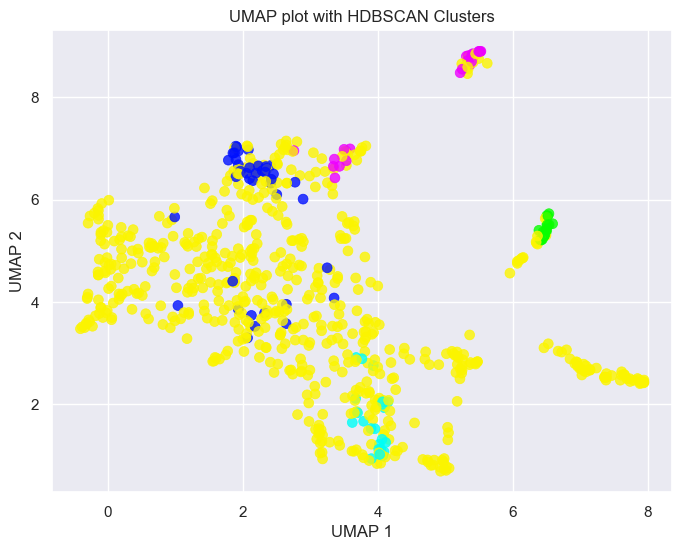

In [6]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(returns_df)

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, metric='manhattan')
cluster_labels = clusterer.fit_predict(df_scaled)
returns_df['HDBSCAN'] = cluster_labels 

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))
sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with HDBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### KMeans

In [ ]:
# Function to calculate WCSS for KMeans
def calculate_wcss(data):
    wcss = []
    for n in range(1, 101): # Let's test for 1 to 10 clusters
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Plot the WCSS to find the elbow
#wcss = calculate_wcss(df_scaled)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 101), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


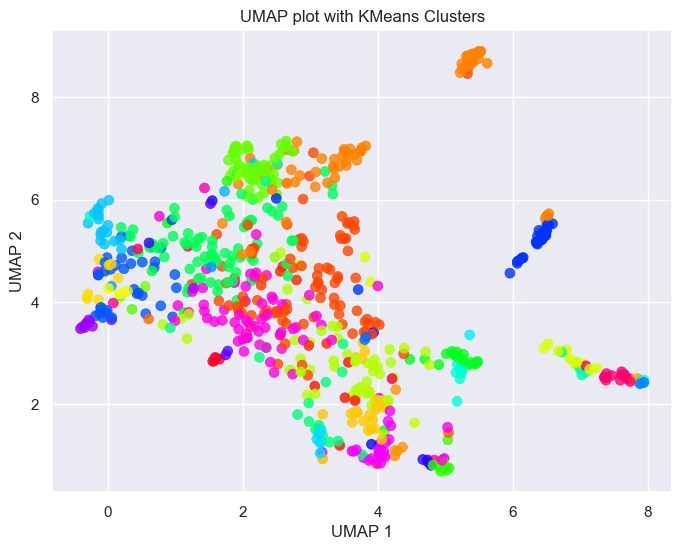

In [7]:
# Define the number of clusters for KMeans and GMM
n_clusters = 80

# K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)
returns_df['KMeans'] = cluster_labels

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters without a legend
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))  # 'hsv' is cyclic, better for many clusters
sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with KMeans Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### GMM

In [ ]:
# Function to calculate BIC and AIC
def calculate_bic_aic(data):
    bics = []
    aics = []
    for n in range(1, 101): # Let's test for 1 to 10 clusters
        gmm = GaussianMixture(n_components=n)
        gmm.fit(data)
        bics.append(gmm.bic(data))
        aics.append(gmm.aic(data))
    return bics, aics

# Plot the BIC and AIC
#bics, aics = calculate_bic_aic(df_scaled)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 101), bics, label='BIC')
plt.plot(range(1, 101), aics, label='AIC')
plt.legend()
plt.title('BIC and AIC Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Scores')
plt.show()

D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


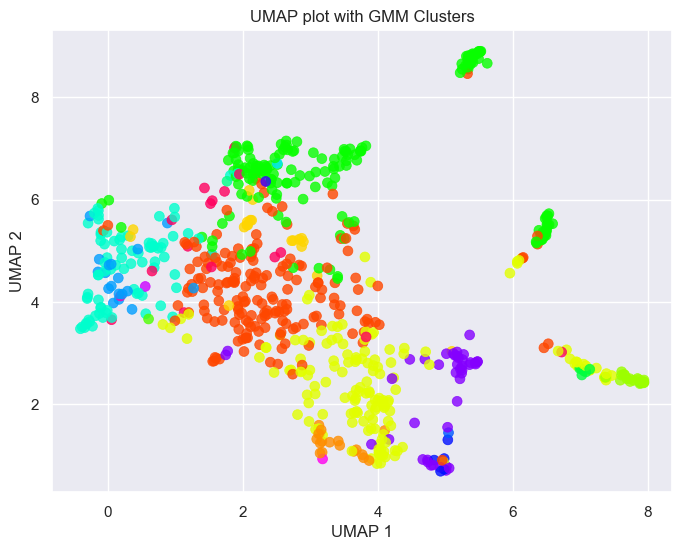

In [8]:
# Define the number of clusters for GMM
n_clusters = 20

# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
cluster_labels = gmm.fit_predict(df_scaled)
returns_df['GMM'] = cluster_labels

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters without a legend
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))  # 'hsv' is cyclic, better for many clusters
sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with GMM Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### DBSCAN

In [ ]:
# DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=2)
cluster_labels = dbscan.fit_predict(df_scaled)
returns_df['DBSCAN'] = cluster_labels

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))

sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with DBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### Other Clustering Models

D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


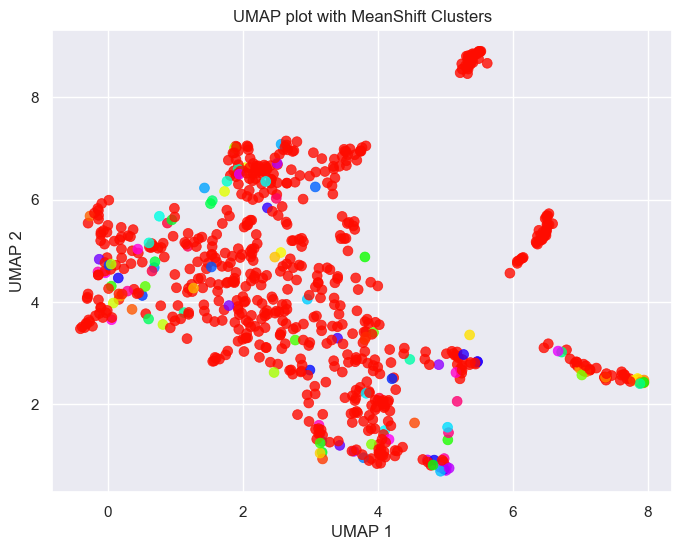

D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


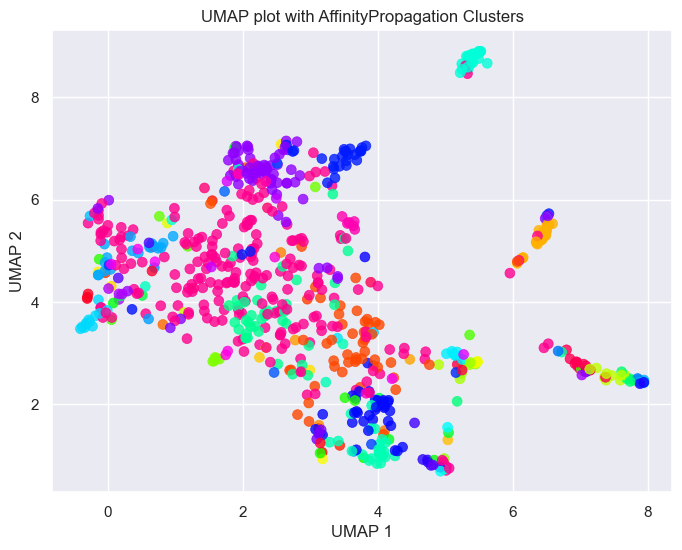

D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


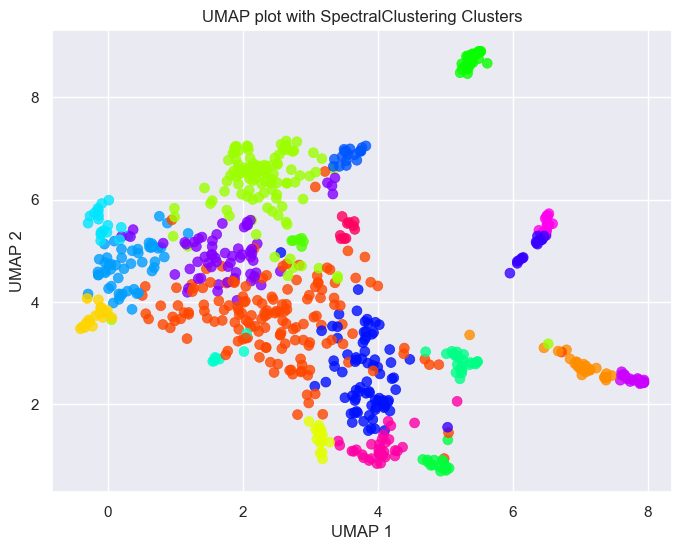

D:\Applications\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


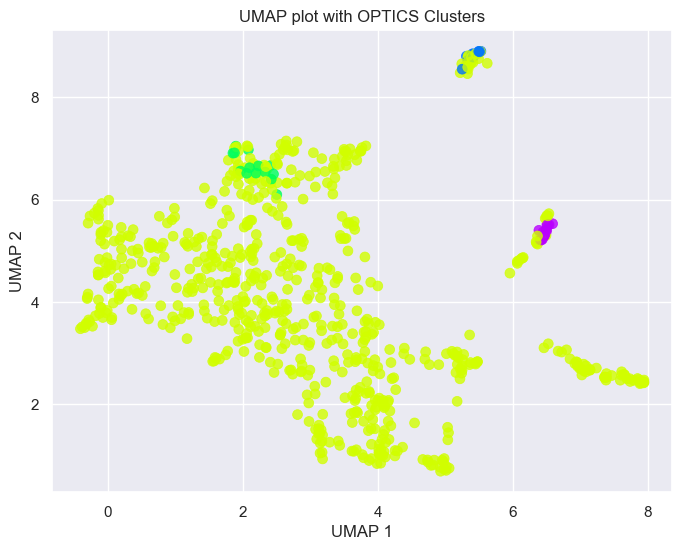

In [9]:
def apply_clustering(model, data):
    # Fit the model and predict the cluster labels
    cluster_labels = model.fit_predict(data)
    return cluster_labels

# List of clustering models to apply
clustering_models = [
    MeanShift(),  # May need bandwidth parameter adjusted
    AffinityPropagation(),  # Beware, complexity can be high
    SpectralClustering(n_clusters=n_clusters, random_state=42, affinity='nearest_neighbors'),
    OPTICS(min_samples=5, xi=0.05, min_cluster_size=10),  # Adjust parameters as needed
]

clustering_labels = {}

for model in clustering_models:
    model_name = model.__class__.__name__
    clustering_labels[model_name] = apply_clustering(model, df_scaled)
    returns_df[model_name] = clustering_labels[model_name]

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

for model_name, labels in clustering_labels.items():
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette('hsv', len(np.unique(labels)))  # Adjust the palette as needed
    sns.scatterplot(*embedding.T, hue=labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
    plt.title(f'UMAP plot with {model_name} Clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

In [ ]:
clusters = returns_df[returns_df.columns[-8:]]
clusters = clusters.reset_index()
clusters.rename(columns={'index': 'Ticker'}, inplace=True)
clusters.to_csv('stock_clusters.csv', index=False)
clusters = pd.read_csv('stock_clusters.csv')
clusters

# Portfolio Construction

In [17]:
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-12-31')
ticker_list = get_tickers(start_date, end_date, sp_500)
ticker_list = np.append(ticker_list, 'SPY')

In [15]:
def get_tickers(start_date, end_date, sp500):
    sp500['date'] = pd.to_datetime(sp500['date'])
    return sp500.loc[(sp500['date'] >= start_date) & (sp500['date'] <= end_date), 'ticker'].unique()
    
def get_weeks_df(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, inclusive='both')
    all_dates_df = pd.DataFrame({'date': date_range})
    all_dates_df.set_index('date', inplace=True)
    all_dates_df = all_dates_df.resample('W-MON').first()
    all_dates_df.reset_index(inplace=True)
    return all_dates_df
    
def weekly_returns(start_date, end_date, ticker_list):
    # Specify the directory path
    directory_path = 'returns'

    # List all files in the directory
    files = os.listdir(directory_path)
    all_dfs = []
    
    # Date Range
    all_dates_df = get_weeks_df(start_date, end_date)
    time_diff = (end_date - start_date).days
    
    # Iterate through each file in the directory
    for ticker in ticker_list:
        filename = ticker + '.feather'
        file_path = os.path.join(directory_path, filename)
        #print(file_path)
        df = pd.read_feather(file_path)
        df['date'] = pd.to_datetime(df['date'])
        df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]
        df = df.dropna(subset=['ret'])
        
        if len(df) >= (0.6 * time_diff):
            df['ret'] = 1 + df['ret']
            df.set_index('date', inplace=True)
            df = df.resample('W-MON').agg({'ticker': 'last', 'ret': 'prod'})
            df['ret'] = df['ret'] - 1
            df.reset_index(inplace=True)
            df = pd.merge(all_dates_df, df, how='left', on=['date']).drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)
            #print(df)
            ticker = df['ticker'].iloc[df['ticker'].first_valid_index()]
            df['ticker'] = df['ticker'].fillna(ticker)
            all_dfs.append(df)

            print(f"", end=' ')
            
    merged_df = all_dates_df
    for df in all_dfs:
        ticker = df['ticker'].iloc[0]
        df = df.rename(columns={'ret': ticker})
        df.drop(columns=['ticker', 'date'], inplace=True)
        merged_df = pd.concat([merged_df, df], axis=1)
    
    return merged_df.fillna(0).set_index('date')

def get_series(all_dates_df, factor_df, factor_name, ticker):
    factor_df['date'] = pd.to_datetime(factor_df['date'])
    merged_df = pd.merge(factor_df, all_dates_df, on='date', how='outer').drop_duplicates(subset=['date']).sort_values(by='date').fillna(method='ffill')
    merged_df = pd.merge(all_dates_df, merged_df, on='date', how='inner').sort_values(by='date').fillna(method='ffill')
    
    series = pd.to_numeric(merged_df[factor_name])
    series.name = ticker
    return series

def get_factors(start_date, end_date, ticker_list):
    factors_dict = {}
    all_dates_df = get_weeks_df(start_date, end_date)
    
    fact_list = ['momentum', 'risk_adj_momentum', 'pe_op_basic', 'bm', '1M_reversal', 'risk_adj_1M_reversal']
    for fact in fact_list:
        factors_dict[fact] = []
    
    momentum_path = 'factors/momentum'
    finratios_path = 'factors/finratios'
    reversal_path = 'factors/1_month_reversal'
    
    data = []
    counter = 0

    for ticker in ticker_list:
        filename = ticker + '.csv'
        
        momentum = pd.read_csv(os.path.join(momentum_path, filename))[['date', 'momentum', 'risk_adj_momentum']]
        finratio = pd.read_csv(os.path.join(finratios_path, filename))[['date', 'pe_op_basic', 'bm']]
        reversal = pd.read_csv(os.path.join(reversal_path, filename))[['date', '1M_reversal*', 'risk_adj_1M_reversal*']]
        
        factors_dict['momentum'].append(get_series(all_dates_df, momentum, 'momentum', ticker))
        factors_dict['risk_adj_momentum'].append(get_series(all_dates_df, momentum, 'risk_adj_momentum', ticker))
        factors_dict['pe_op_basic'].append(get_series(all_dates_df, finratio, 'pe_op_basic', ticker))
        factors_dict['bm'].append(get_series(all_dates_df, finratio, 'bm', ticker))
        factors_dict['1M_reversal'].append(get_series(all_dates_df, reversal, '1M_reversal*', ticker))
        factors_dict['risk_adj_1M_reversal'].append(get_series(all_dates_df, reversal, 'risk_adj_1M_reversal*', ticker))
        
        #print(f'{ticker}', end=' ')
    
    for fact in fact_list:
        factors_dict[fact] = pd.concat(factors_dict[fact], axis=1)
        factors_dict[fact]['date'] = pd.to_datetime(all_dates_df['date'])
        factors_dict[fact].set_index('date', inplace=True)
    
    return factors_dict

def market_cap_wts(sp_500, start_date, end_date, ticker_list):
    df = sp_500.loc[sp_500['date'] >= (start_date - pd.DateOffset(days=35))].loc[sp_500['date'] <= (end_date + pd.DateOffset(days=35))]
    df['mcap'] = df['prc'] * df['shrout'] * 1000
    df = df[['ticker', 'date', 'mcap']]
    pivot_df = df.pivot(index='date', columns='ticker', values='mcap')
    pivot_df.columns.name = None
    columns_to_drop = [col for col in pivot_df.columns if col not in ticker_list]
    pivot_df.drop(columns=columns_to_drop, inplace=True)
    pivot_df.reset_index(inplace=True)
    weekly_dates = get_weeks_df(start_date, end_date)
    df = pd.merge(pivot_df, weekly_dates, on='date', how='outer').drop_duplicates('date').sort_values(by='date').fillna(method='ffill').fillna(method='bfill')
    df = pd.merge(df, weekly_dates, on='date', how='inner').sort_values(by='date')
    series = df['date']
    df.drop(columns=['date'], inplace=True)
    df = df.div(df.sum(axis=1), axis=0)
    df['date'] = pd.to_datetime(series)
    df.set_index('date', inplace=True)
    return df

def render_returns_data_for_clustering(start_date, end_date, ticker_list):
    directory_path = 'returns'
    files = os.listdir(directory_path)
    new_start_date = start_date - pd.DateOffset(days=365)
    new_end_date = end_date - pd.DateOffset(days=365)

    dfs = []  # A list to store DataFrames

    for ticker in ticker_list:
        filename = ticker + '.feather'
        file_path = os.path.join(directory_path, filename)
        df = pd.read_feather(file_path)
        df = df[['ticker', 'date', 'ret']]
        ticker = filename.split('.feather')[0]
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= new_start_date) & (df['date'] <= new_end_date)]
        df.rename(columns={'ret': ticker}, inplace=True)
        df.drop(columns=['ticker'], inplace=True)
        dfs.append(df.reset_index(drop=True))
        
    dfs = [df.drop_duplicates(subset=['date']) for df in dfs]
    merged_df = reduce(lambda x, y: pd.merge(x, y, on='date', how='left'), dfs)
    
    returns_df = merged_df.set_index('date')
    returns_df = returns_df.drop(columns='SPY')
    nan_percentage = (returns_df.isnull().sum() / len(returns_df)) * 100
    threshold = 100
    columns_to_drop = nan_percentage[nan_percentage >= threshold].index
    returns_df = returns_df.drop(columns=columns_to_drop)
    returns_df = returns_df.T
    returns_df = returns_df.fillna(0)
    
    scaler = StandardScaler()
    return returns_df, scaler.fit_transform(returns_df)

def get_clusters(start_date, end_date, ticker_list):
    dfs = [] 
    returns_df, df_scaled = render_returns_data_for_clustering(start_date, end_date, ticker_list)
   
    # List of clustering models to apply
    clustering_models = [
        AffinityPropagation(),  # Beware, complexity can be high
        SpectralClustering(n_clusters=80, random_state=42, affinity='nearest_neighbors'),
        KMeans(n_clusters=80, random_state=42),
        GaussianMixture(n_components=80, random_state=42)
    ]

    clustering_labels = pd.DataFrame(index=returns_df.index)

    for model in clustering_models:
        model_name = model.__class__.__name__
        clustering_labels[model_name] = apply_clustering(model, df_scaled)
        #returns_df[model_name] = clustering_labels[model_name]

    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(df_scaled)
    clustering_labels.reset_index(inplace=True)
    clustering_labels.rename(columns={clustering_labels.columns[0]: 'Ticker'}, inplace=True)
    clustering_labels = clustering_labels.T
    clustering_labels.columns = clustering_labels.iloc[0]
    clustering_labels = clustering_labels[1:]
    clustering_labels.columns.name = None
    cluster_dict = {}
    for i in range(len(clustering_labels)):
        cluster_dict[clustering_labels.index[i]] = clustering_labels.loc[clustering_labels.index[i] == clustering_labels.index].reset_index(drop=True)
    
    #add_other_clustering_files(cluster_dict)
    return cluster_dict

def add_other_clustering_files(cluster_dict):
    # Specify the directory path
    directory_path = 'other_clusters'
    
    # List all files in the directory
    files = os.listdir(directory_path)

    # Iterate through each file in the directory
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        cluster_dict[filename] = pd.read_csv(file_path)
        cluster_dict[filename].drop(columns=cluster_dict[filename].columns[0], inplace=True)
        cluster_dict[filename].fillna(-1, inplace=True)
        cluster_dict[filename] = cluster_dict[filename].astype(int)

def apply_clustering(model, data):
    # Fit the model and predict the cluster labels
    cluster_labels = model.fit_predict(data)
    return cluster_labels

def normalize(weights):
    weights = weights.copy()
    total_sum = weights.abs().sum(axis=1)
    normalized_weights = weights.div(total_sum + 10e-12, axis=0)
    return normalized_weights

def enforce_boundary(weights, max_weights, min_weights):
    weights = normalize(weights)
    max_exceeded = weights.abs() > max_weights
    min_exceeded = weights.abs() < min_weights

    if max_exceeded.any().any():
        weights[max_exceeded] = max_weights * weights[max_exceeded].abs()/weights[max_exceeded]

    if min_exceeded.any().any():
        weights[min_exceeded] = min_weights * weights[min_exceeded].abs()/weights[min_exceeded]

    return normalize(weights)

def add_to_print(print_df, scheme, period_returns, weights_df):
    returns = period_returns * weights_df
    returns = (returns.sum(axis=1) * 100).round(4)
    returns.name = scheme
    print_df = pd.concat([print_df, returns], axis=1)
    return print_df

def run_framework(start_date, end_date, market_cap_wt_df, factor_dict, returns_df, ticker_list):
    print_df = pd.DataFrame()
    returns = returns_df.copy()
    market_cap_wt = market_cap_wt_df.copy()
    
    spy_returns = returns['SPY']
    spy_returns.name = 'SPY'
    returns.drop(columns = ['SPY'], inplace=True)
    market_cap_wt = market_cap_wt[returns.columns]
    
    print('Generating Clusters')
    cluster_dict = get_clusters(start_date, end_date, ticker_list)
    
    print_df = pd.concat([print_df, (spy_returns * 100).round(4)], axis=1)
    portfolio_returns = []

    print('Calculating Returns For Factors')
    for fact_key in factor_dict:
        weights = factor_dict[fact_key].copy()
        max_wt, min_wt = 5/100, 0.01/100
        weights = enforce_boundary(weights, max_wt, min_wt)
        print_df = add_to_print(print_df, fact_key, returns, weights)
        
        for key in cluster_dict:
            cluster_df = cluster_dict[key]
            for column in returns.columns:
                if column not in cluster_df.columns:
                    cluster_df[column] = -1
            cluster_df = cluster_df[returns.columns]
            cluster_df = cluster_df.T
            cluster_df.columns = ['Cluster']

            ## Individual Cluster portfolios
            for cluster in cluster_df['Cluster'].unique():
                cluster_mask = cluster_df['Cluster'] == cluster
                cluster_wt_df = factor_dict[fact_key].copy()[returns.columns]
                for stock in cluster_wt_df.columns:
                    if not cluster_mask[stock]:
                        cluster_wt_df[stock] = 0.0

                # Add the DataFrame to the dictionary
                max_wt, min_wt = market_cap_wt * 5, market_cap_wt / 5
                weights = enforce_boundary(cluster_wt_df, max_wt, min_wt)
                print_df = add_to_print(print_df, str(key)+'-'+str(cluster)+'-'+str(fact_key), returns, weights)
                
            ### Factor and Market Cap based clustering portfolios
            factor_df = factor_dict[fact_key].copy()[returns.columns]
            market_cap_df = market_cap_wt.copy()

            # Calculate cluster weights
            cluster_weights = market_cap_df.groupby(cluster_df['Cluster'], axis=1).sum()

            # Calculate total factor sum for each cluster
            factor_sum = factor_df.groupby(cluster_df['Cluster'], axis=1).sum()

            adjusted_factor_wt = factor_df.copy()
            for stock in market_cap_df.columns:
                cluster = cluster_df.loc[stock, 'Cluster']
                adjusted_factor_wt[stock] = factor_df[stock] / factor_sum[cluster]

            # Initialize a DataFrame for final weights
            final_weights = pd.DataFrame(index=adjusted_factor_wt.index, columns=returns.columns)

            # Multiply each stock's adjusted market cap weight by its cluster's weight
            for stock in adjusted_factor_wt.columns:
                cluster = cluster_df.loc[stock, 'Cluster']
                final_weights[stock] = adjusted_factor_wt[stock] * cluster_weights[cluster]

            #print(cluster_weights)
            #print(final_weights)
            #print(max_wt)

            weights = enforce_boundary(final_weights, max_wt, min_wt)
            print_df = add_to_print(print_df, f'{key}-{fact_key}-mcap', returns, weights)
        
    save_csv(print_df.T)
    print('Save to CSV Complete')
    return returns, factor_dict
    
def save_csv(data_frame, base_folder='ReturnSeries', file_name_prefix="FactorReturns"):
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")
    folder_path = os.path.join(base_folder, today_date)
    os.makedirs(folder_path, exist_ok=True)
    existing_files = [file for file in os.listdir(folder_path) if file.startswith(file_name_prefix)]
    new_file_name = f"{file_name_prefix}V{len(existing_files) + 1}.csv"
    file_path = os.path.join(folder_path, new_file_name)
    data_frame.to_csv(file_path)
    return file_path

In [25]:
cluster_dict = {}
add_other_clustering_files(cluster_dict)
cluster_dict

{'cluster_100_2018.csv':     A  AAL  AAP  AAPL  ABBV  ABC  ABMD  ABT  ACN  ADBE  ...  XEL  XLNX  XOM  \
 0  32   96   65    18    21   69    -1    0   90    20  ...   51    18   22   
 
    XRAY  XRX  XYL  YUM  ZBH  ZION  ZTS  
 0    11    7   38   58    0    97    0  
 
 [1 rows x 496 columns],
 'cluster_10_2018.csv':    A  AAL  AAP  AAPL  ABBV  ABC  ABMD  ABT  ACN  ADBE  ...  XEL  XLNX  XOM  \
 0  1    3    4     1     7    7    -1    1    9     1  ...    5     1    6   
 
    XRAY  XRX  XYL  YUM  ZBH  ZION  ZTS  
 0     7    3    8    9    1     2    1  
 
 [1 rows x 496 columns],
 'cluster_20_2018.csv':     A  AAL  AAP  AAPL  ABBV  ABC  ABMD  ABT  ACN  ADBE  ...  XEL  XLNX  XOM  \
 0  14    3    6     0    18    7    -1   14    1     0  ...    2     0   13   
 
    XRAY  XRX  XYL  YUM  ZBH  ZION  ZTS  
 0     7    3    9    1   14    11   14  
 
 [1 rows x 496 columns],
 'cluster_35_2018.csv':     A  AAL  AAP  AAPL  ABBV  ABC  ABMD  ABT  ACN  ADBE  ...  XEL  XLNX  XOM  \
 0  32   2

In [18]:
market_cap_wt = market_cap_wts(sp_500, start_date, end_date, ticker_list)
factor_dict = get_factors(start_date, end_date, ticker_list)
returns = weekly_returns(start_date, end_date, ticker_list)

In [19]:
returns, factor_dict = run_framework(start_date, end_date, market_cap_wt, factor_dict, returns, ticker_list)

Generating Clusters


D:\Applications\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\Applications\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Calculating Returns For Factors
Save to CSV Complete


In [30]:
def plot_barplot(spy, data_points, labels, type_of_value):
    first_element = spy
    last_elements = data_points
    last_labels = labels

    # Define a color palette for the bars
    colors = sns.color_palette("Blues", len(last_labels))

    plt.figure(figsize=(12, 6))
    #bars = plt.bar(last_labels, last_elements, color=colors, alpha=0.7, label='Others', width=0.5)

#     # Add data labels on top of the bars
#     for bar, value in zip(bars, last_elements):
#         plt.text(bar.get_x() + bar.get_width() / 2, value, str(value), ha='center', va='bottom')

    plt.axvline(x=first_element, color='red', linestyle='--', label='SPY')

    # If you want to use a horizontal bar plot
    plt.barh(last_labels, last_elements, color=colors, alpha=0.7, label='Others')  # Use barh for horizontal bars
    plt.xlabel(type_of_value)
    plt.ylabel('Labels')
    plt.title('Bar Plot of Factor Portfolios vs. SPY')
    plt.legend()
    
    plt.grid(True)  # Add grid lines

    plt.xticks(rotation=45)
    
    # Set background color
    plt.gca().set_facecolor('#F5F5F5')
    plt.show()

In [45]:
weekly_returns = pd.read_csv('ReturnSeries\\2023-12-11\\FactorReturnsV2.csv')
weekly_returns.rename(columns={'Unnamed: 0':'Portfolio'}, inplace=True)
weekly_returns

,Portfolio,2018-01-01 00:00:00,2018-01-08 00:00:00,2018-01-15 00:00:00,2018-01-22 00:00:00,2018-01-29 00:00:00,2018-02-05 00:00:00,2018-02-12 00:00:00,2018-02-19 00:00:00,2018-02-26 00:00:00,...,2018-10-29 00:00:00,2018-11-05 00:00:00,2018-11-12 00:00:00,2018-11-19 00:00:00,2018-11-26 00:00:00,2018-12-03 00:00:00,2018-12-10 00:00:00,2018-12-17 00:00:00,2018-12-24 00:00:00,2018-12-31 00:00:00
0,SPY,0.0,2.6456,1.4603,1.7163,0.7039,-7.2889,0.5342,2.9283,1.7539,...,-4.0544,3.6118,-0.2999,-1.2731,-0.5946,4.4112,-5.4529,-3.2984,-7.6843,6.6485
1,momentum,0.0,1.9775,1.6693,1.7806,0.7206,-4.8907,0.1377,2.7497,1.7404,...,-3.6851,2.5258,0.1167,-1.7668,-0.4635,1.3775,-0.1861,-0.2496,1.9540,-0.5025
2,AffinityPropagation-56-momentum,0.0,2.3145,1.9290,1.1606,-0.2494,-6.7199,0.3236,2.5747,2.0718,...,-2.8446,2.6092,0.3861,-0.6710,-1.1614,0.4212,1.1188,-0.2020,1.8790,-1.6519
3,AffinityPropagation-8-momentum,0.0,5.6520,1.1338,2.5186,1.5863,-4.9088,0.3350,3.4010,3.0530,...,-6.1495,2.8748,-0.1310,-3.9341,2.0252,6.7955,-4.3210,-3.5125,-2.1446,5.5834
4,AffinityPropagation-14-momentum,0.0,1.5586,0.5814,2.5609,2.1674,-4.9397,0.2759,2.2692,0.9732,...,-1.7415,2.5132,0.9415,-0.8397,-0.1539,2.4777,-2.0181,-1.7779,-1.1437,2.7538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,GaussianMixture-50-risk_adj_1M_reversal,0.0,2.4157,3.3347,-8.2251,7.9760,-0.1986,23.1596,6.8174,-2.7223,...,11.0007,5.0324,-5.9083,-0.0937,2.6266,2.5594,-0.6833,-0.0000,-20.8794,8.6578
1965,GaussianMixture-79-risk_adj_1M_reversal,0.0,0.9762,1.5274,-1.4664,-9.5091,-3.9086,-0.5779,3.7335,-2.8879,...,-4.0895,4.8914,-2.6845,-1.7497,-2.4922,-2.6307,-6.6270,-4.1310,-11.2187,9.3008
1966,GaussianMixture-27-risk_adj_1M_reversal,0.0,6.5710,3.1745,6.4278,0.8379,-4.5397,7.2239,-12.3181,4.1525,...,-6.1676,14.2752,-4.9566,-5.7561,1.5112,7.7395,-5.7895,-8.5303,-10.1204,11.5405
1967,GaussianMixture-32-risk_adj_1M_reversal,0.0,3.7545,-0.6489,1.5906,-2.3901,-6.8036,-3.5420,6.7839,3.0998,...,-13.1583,7.2294,-4.9659,3.3607,-3.9540,2.6164,-10.2880,-12.0143,-3.2415,8.2059


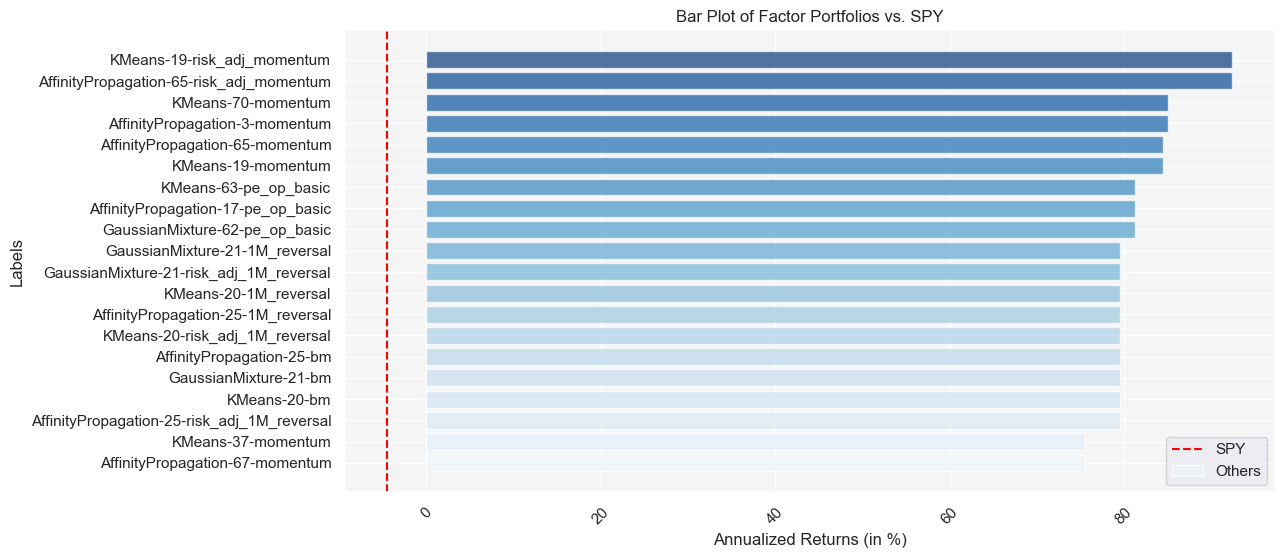

In [46]:
sum_returns = (1+(0.01 * weekly_returns.apply(pd.to_numeric, errors='coerce'))).prod(axis=1) - 1
top_20 = pd.DataFrame()
top_20['Returns'] = sum_returns
top_20['Labels'] = weekly_returns['Portfolio'].values
spy = top_20.loc[top_20['Labels']=='SPY', 'Returns'].values[0] * 100
top_20 = top_20.sort_values(by='Returns').tail(20)
plot_barplot(spy, top_20['Returns'].values * 100, top_20['Labels'].values, 'Annualized Returns (in %)')

C:\Users\food4thought\AppData\Local\Temp\ipykernel_2304\4077059439.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)


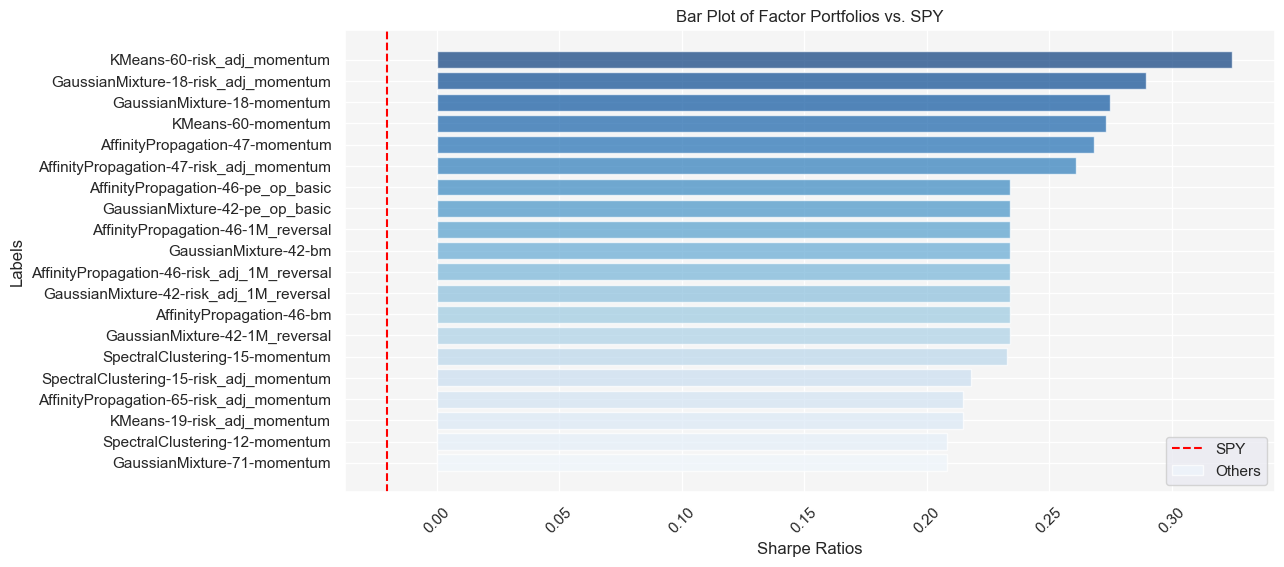

In [47]:
sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)
top_20 = pd.DataFrame()
top_20['SR'] = sharpe_ratios
top_20['Labels'] = weekly_returns['Portfolio'].values
spy = top_20.loc[top_20['Labels']=='SPY', 'SR'].values[0]
top_20 = top_20.dropna().sort_values(by='SR').tail(20)
plot_barplot(spy, top_20['SR'].values, top_20['Labels'].values, 'Sharpe Ratios')

In [48]:
weekly_returns = pd.read_csv('ReturnSeries\\2023-12-11\\FactorReturnsV2.csv')
weekly_returns.rename(columns={'Unnamed: 0':'Portfolio'}, inplace=True)
weekly_returns = weekly_returns[~weekly_returns['Portfolio'].str.match(r'.*-\d+-.*')]
weekly_returns

,Portfolio,2018-01-01 00:00:00,2018-01-08 00:00:00,2018-01-15 00:00:00,2018-01-22 00:00:00,2018-01-29 00:00:00,2018-02-05 00:00:00,2018-02-12 00:00:00,2018-02-19 00:00:00,2018-02-26 00:00:00,...,2018-10-29 00:00:00,2018-11-05 00:00:00,2018-11-12 00:00:00,2018-11-19 00:00:00,2018-11-26 00:00:00,2018-12-03 00:00:00,2018-12-10 00:00:00,2018-12-17 00:00:00,2018-12-24 00:00:00,2018-12-31 00:00:00
0,SPY,0.0,2.6456,1.4603,1.7163,0.7039,-7.2889,0.5342,2.9283,1.7539,...,-4.0544,3.6118,-0.2999,-1.2731,-0.5946,4.4112,-5.4529,-3.2984,-7.6843,6.6485
1,momentum,0.0,1.9775,1.6693,1.7806,0.7206,-4.8907,0.1377,2.7497,1.7404,...,-3.6851,2.5258,0.1167,-1.7668,-0.4635,1.3775,-0.1861,-0.2496,1.9540,-0.5025
87,AffinityPropagation-momentum-mcap,0.0,2.3075,1.1912,1.8367,0.8420,-5.1132,-0.0028,2.5846,1.4303,...,-2.8890,2.1197,-0.1154,-0.7440,0.3526,1.8523,-1.3404,-1.2297,-1.3731,2.2603
168,SpectralClustering-momentum-mcap,0.0,1.9771,1.0781,1.4681,0.9473,-4.7581,0.5656,2.2057,1.4386,...,-2.3165,2.4919,-0.1300,-0.5869,-0.0681,0.5957,-1.1310,-0.4521,-2.0003,1.7399
248,KMeans-momentum-mcap,0.0,1.9820,1.0372,1.8919,0.8857,-4.8722,0.2178,2.5783,1.3560,...,-2.0176,2.1102,-0.0353,-0.8532,0.1127,0.4961,-0.7775,-1.3053,-1.0394,0.8284
328,GaussianMixture-momentum-mcap,0.0,1.9166,1.0045,1.6178,1.0557,-4.8952,0.1288,1.1008,1.1123,...,-2.7695,2.3834,-0.8489,-0.9636,-0.1075,1.3749,-2.4404,-1.4449,-1.8074,-1.4109
329,risk_adj_momentum,0.0,1.9580,1.6504,1.7602,0.7130,-4.8355,0.1362,2.7169,1.7178,...,-3.6846,2.5390,0.1193,-1.8058,-0.4806,1.4211,-0.1897,-0.2580,-2.0119,0.5199
415,AffinityPropagation-risk_adj_momentum-mcap,0.0,2.3076,1.1912,1.8367,0.8420,-5.1134,-0.0028,2.5847,1.4303,...,-2.8899,2.1194,-0.1153,-0.7442,0.3536,1.8488,-1.3387,-1.2272,-1.3451,2.2964
496,SpectralClustering-risk_adj_momentum-mcap,0.0,1.9762,1.0781,1.4681,0.9473,-4.7587,0.5655,2.2053,1.4388,...,-2.3152,2.4920,-0.1301,-0.5873,-0.0680,0.6496,-1.1455,-0.4481,-2.0314,1.7566
576,KMeans-risk_adj_momentum-mcap,0.0,1.9821,1.0373,1.8919,0.8857,-4.8724,0.2179,2.5783,1.3560,...,-2.0174,2.1105,-0.0355,-0.8529,0.1129,0.4962,-0.7783,-1.3049,-0.4260,0.8478


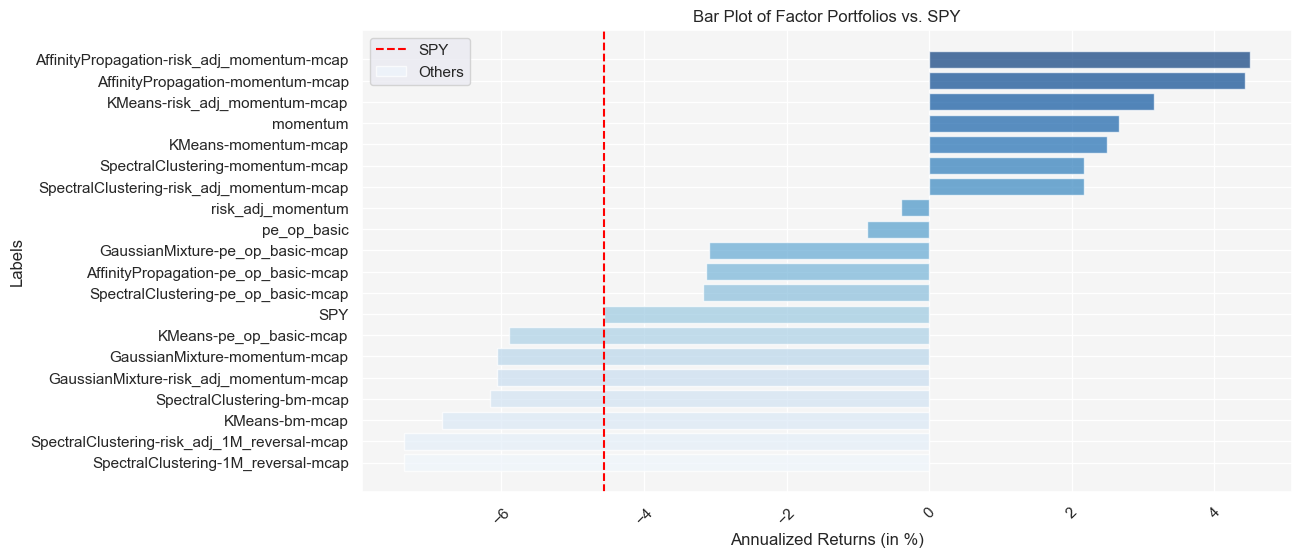

In [49]:
sum_returns = (1+(0.01 * weekly_returns.apply(pd.to_numeric, errors='coerce'))).prod(axis=1) - 1
top_20 = pd.DataFrame()
top_20['Returns'] = sum_returns
top_20['Labels'] = weekly_returns['Portfolio'].values
spy = top_20.loc[top_20['Labels']=='SPY', 'Returns'].values[0] * 100
top_20 = top_20.sort_values(by='Returns').tail(20)
plot_barplot(spy, top_20['Returns'].values * 100, top_20['Labels'].values, 'Annualized Returns (in %)')

C:\Users\food4thought\AppData\Local\Temp\ipykernel_2304\824390115.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)


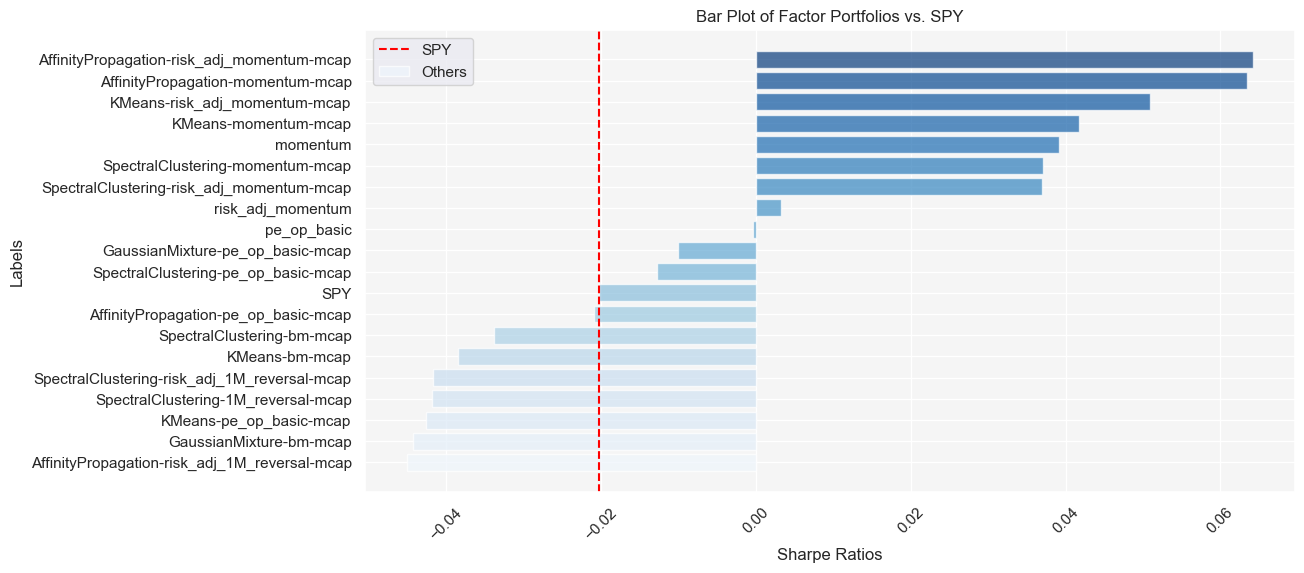

In [50]:
sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)
top_20 = pd.DataFrame()
top_20['SR'] = sharpe_ratios
top_20['Labels'] = weekly_returns['Portfolio'].values
spy = top_20.loc[top_20['Labels']=='SPY', 'SR'].values[0]
top_20 = top_20.sort_values(by='SR').tail(20)
plot_barplot(spy, top_20['SR'].values, top_20['Labels'].values, 'Sharpe Ratios')